In [54]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib  

In [55]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np


In [56]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, tgt, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(src)
        output = self.decoder(tgt, memory, tgt_mask)
        
        return output

In [57]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [58]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N = 1):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        
    def forward(self, x):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return x

In [59]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [60]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [61]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.feed_forward = feed_forward
        self.size = size

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        return self.feed_forward(x)

In [63]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, tgt_mask)
        return self.norm(x)

In [64]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # todo check src_mask can be None or should be something valid
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, None))
        return self.sublayer[2](x, self.feed_forward)

In [65]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [66]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

In [67]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [68]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model_input, d_model_output, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model_input, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [69]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

## Full Model

In [70]:
def make_model(N=6, d_model_input=300, d_model_output=362, d_ff=2048, h=2, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model_output, dropout)
    ff_encoder = PositionwiseFeedForward(d_model_input, d_model_output, d_ff, dropout)
    ff_decoder = PositionwiseFeedForward(d_model_output, d_model_output, d_ff, dropout)
    position = PositionalEncoding(d_model_output, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model_input, c(ff_encoder), dropout), N=1),
        Decoder(DecoderLayer(d_model_output, c(attn), c(attn), c(ff_decoder), dropout), N))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [71]:
# Small example model.
tmp_model = make_model()
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=300, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=362)
          (dropout): Dropout(p=0.1)
        )
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=362, out_features=362)
            (1): Linear(in_features=362, out_features=362)
            (2): Linear(in_features=362, out_features=362)
            (3): Linear(in_features=362, out_features=362)
          )
        )
        (src_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=362, out_features=362)
            (1): Linear(in_features=362, out_features=362)
            (2): Linear(in_features=362, out_features=362)
            (3): Li

# Training

This section describes the training regime for our models.


In [72]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.encoder.layers[0].size, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [73]:
from google.colab import drive
drive.mount('/content/drive')
%cd './drive/My Drive/dlf2020'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/My Drive/dlf2020'
/content/drive/My Drive/dlf2020
 app.py   data	'Data Collection Module'   README.md   requirements.txt   src


In [74]:
# the following code concatenates the 2d points from each file, we find corresponding gloss and its encoding and an array of corresponding sequences 
# we replace z values with 0 currently
max_sequence_length = 0
class PoseDataset(Dataset):
    """PoseDataset."""
    def __init__(self, training_data_json, words_pickle, embeddings_pickle, videos_root_dir, transform=None):
        # we go through the entire folder containing the videos and for each video id we find the gloss and for that gloss we find the embedding from the pickle file
        self.embeddings = []
        self.poses = []
        f = open(training_data_json,'r')
        temp = json.load(f)
        video_gloss_mapping = {}
        for entry in temp:
            gloss = entry['gloss']
            for videos in entry['instances']:
                video_gloss_mapping[videos['video_id']] = gloss
        word_embeddings = []
        words = []
        with (open(embeddings_pickle, "rb")) as openfile:
            while True:
                try:
                    word_embeddings.append(pickle.load(openfile))
                except EOFError:
                    break
        with (open(words_pickle, "rb")) as openfile:
            while True:
                try:
                    words.append(pickle.load(openfile))
                except EOFError:
                    break
        for video_name in os.listdir(videos_root_dir):
            gloss = video_gloss_mapping[video_name[:video_name.index('.'):]]
            data = json.load(open(os.path.join(videos_root_dir,video_name)))
            max_count = max([int(i) for i in list(data.keys())])
            actual_count = 0
            temp = []
            # we add counter at the end of each pose
            # we store 0 for z positions
            for count in data.keys():
                # 'face_keypoints_2d', 'hand_left_keypoints_2d', hand_right_keypoints_2d','pose_keypoints_2d'
                # if people array is empty we need to skip that frame
                if len(data[count]['people']) > 0:
                    # added extra 0 to balance heads for multi headed attention 
                    t = data[count]['people'][0]['pose_keypoints_2d'][:24:] + data[count]['people'][0]['hand_left_keypoints_2d'] + data[count]['people'][0]['hand_right_keypoints_2d'] + data[count]['people'][0]['face_keypoints_2d'] + [actual_count / max_count] + [0]
                    # the following loop converts z coordinates to 0
                    for i in range(2,len(t)-2,3):
                        t[i] = 0
                    temp.append(t)
                    actual_count += 1
            indices = np.argwhere(words[0] == gloss)[0]
            if len(indices) == 1:
                self.embeddings.append(word_embeddings[0][indices[0]].tolist())
                self.poses.append(np.array(temp))
            else:
                print(gloss + "out of vocabulary")
                
        max_rows = max([len(row) for row in self.poses])
        global max_sequence_length
        max_sequence_length = max_rows
        # padding to make all sequences of same length 
        self.poses = [np.vstack((batch , np.zeros((max_rows - len(batch), len(batch[0]))))) for batch in self.poses]
        
        self.embeddings = torch.Tensor(self.embeddings)
        self.poses = torch.Tensor(self.poses)
        
        print(len(self.embeddings),len(self.embeddings[0]),len(self.poses),len(self.poses[0]), len(self.poses[0][0]))
        
    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        sample = {'embedding': self.embeddings[idx], 'poses': self.poses[idx]}
        return sample
        
dataset = PoseDataset("./Data Collection Module/WLASL_v0.3.json", "./data/interim/words.pkl", "data/interim/embeddings.pkl", "data/interim/Training Data/2D Data/")

598 300 598 185 362


In [75]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)


In [76]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src = Variable(batch['embedding'], requires_grad=False)
        trg = Variable(batch['poses'],requires_grad=False)
        tgt_mask = Variable(subsequent_mask(186),requires_grad=False)
        # todo check the way parameters are passed as expected
        # out = model.forward(src, trg[:, :-1], trg_mask[:, :-1, :-1])
        out = model.forward(src, trg, tgt_mask[:, :-1, :-1])
        loss = criterion(out, trg) 
        loss.backward()
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)
            draw_pose(out[0][0],trg[0][0])

In [ ]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, trg_mask = \
            batch.src, batch.trg, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:]) 
        

In [78]:
def draw_pose(output,target):
  # we need to remove the third coordinate from each point
  o = []
  t = []
  for i in range(0,len(output)-2,3):
    o.append(output.data[i])
    o.append(output.data[i+1])
    t.append(target.data[i])
    t.append(target.data[i+1])
  fig = plt.figure(figsize=(8, 6),dpi = 90)
  ax  = fig.add_subplot(111)
  fig2 = plt.figure(figsize=(8, 6),dpi = 90)
  ax2  = fig2.add_subplot(111)
  def drawLine(i,j,pose,ax):
    x_points, y_points = [pose[i*2],pose[j*2]],[-pose[i*2+1],-pose[j*2+1]]
    ax.plot(x_points, y_points, color = 'b')

  # structure = skeletalModel.getSkeletalModelStructure()
  lines4disp = ((0,1),(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(8,13),(13,14),(14,15),(15,16),(8,17),(7,18),(18,19),(19,20),(8,21),(21,22),(22,23),(23,24),(8,25),(25,26),(26,27,(27,28),(4,29),(29,30),(30,31),(31,32),(32,33),29,34),(34,35),(35,36),(36,37),(29,38),(38,39),(39,40),(40,41),(29,42),(42,43),(43,44),(44,45),(29,46),(46,47),(47,48),(48,49))

  for s in lines4disp:
    drawLine(s[0],s[1],t,ax2)
  print(len(t[100::2]), len(t[101::2]))
  # todo resolve the error coming while displaying faces
  ax2.scatter(t[100::2], -1 * t[101::2])


  for s in lines4disp:
    drawLine(s[0],s[1],o,ax)
  # ax.scatter(o[100::2], -1 * o[101::2])
  

1 Variable containing:
 41942.9336
[torch.FloatTensor of size 1]
 9.128709291752769e-07
70 70
11 Variable containing:
 30404.2949
[torch.FloatTensor of size 1]
 5.477225575051661e-06
70 70
21 Variable containing:
 25550.9688
[torch.FloatTensor of size 1]
 1.0041580220928045e-05
70 70
1 Variable containing:
 28342.5371
[torch.FloatTensor of size 1]
 1.460593486680443e-05
70 70
11 Variable containing:
 69353.3359
[torch.FloatTensor of size 1]
 1.9170289512680815e-05
70 70
21 Variable containing:
 32577.3008
[torch.FloatTensor of size 1]
 2.3734644158557197e-05
70 70


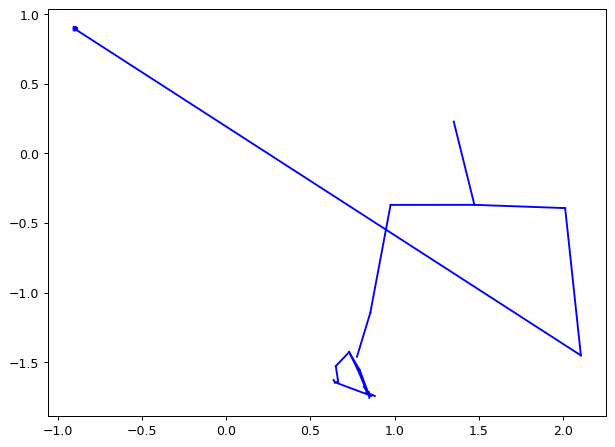

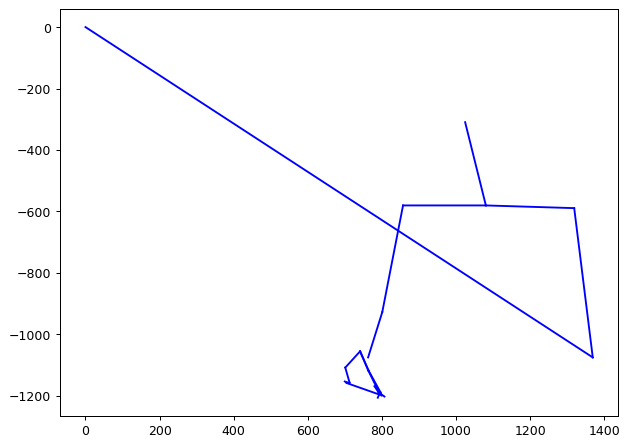

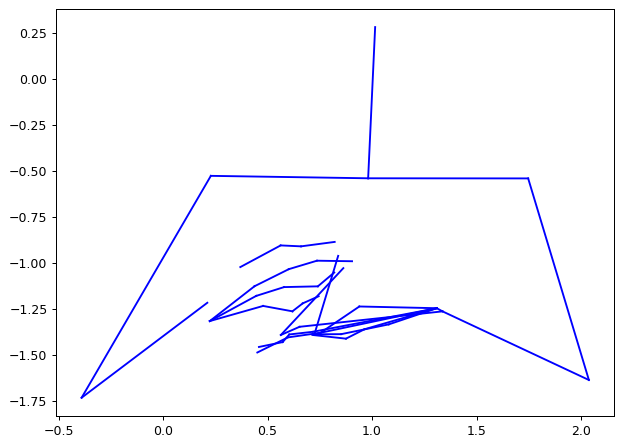

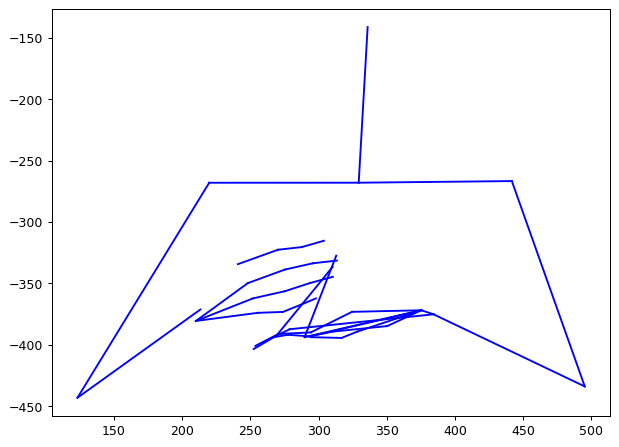

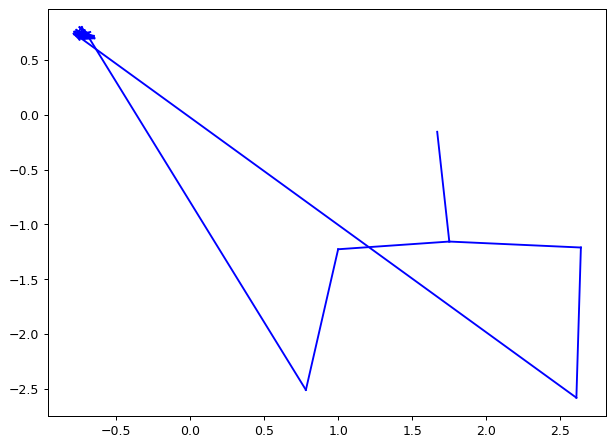

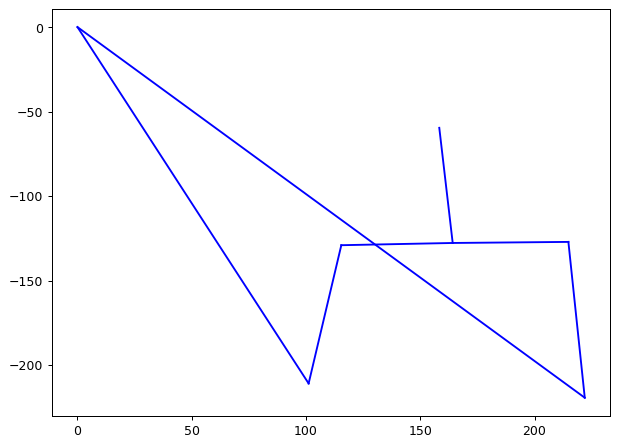

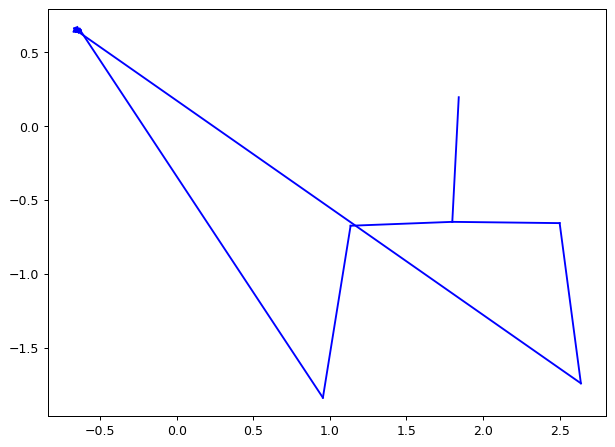

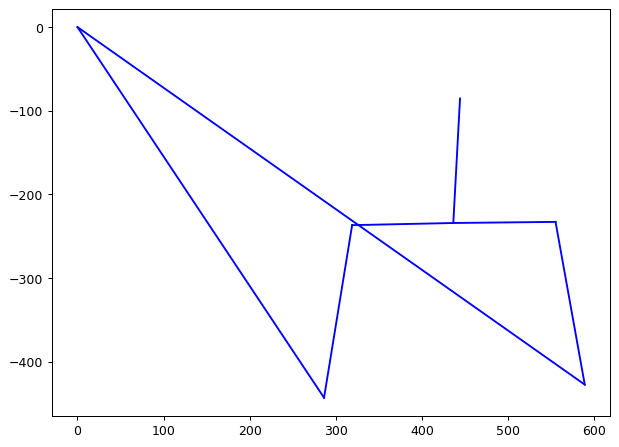

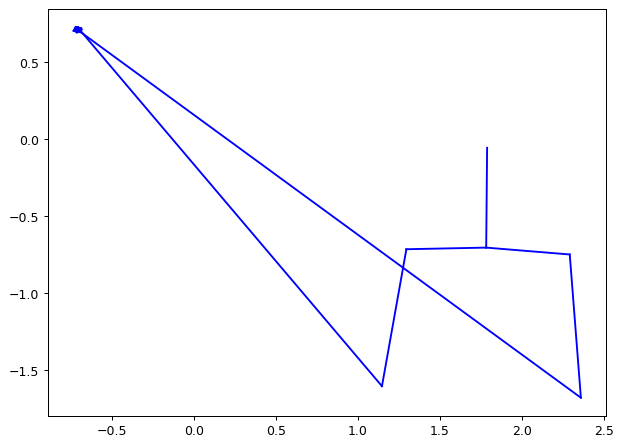

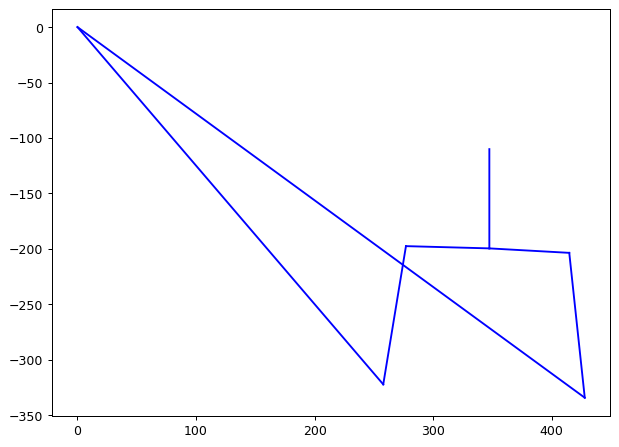

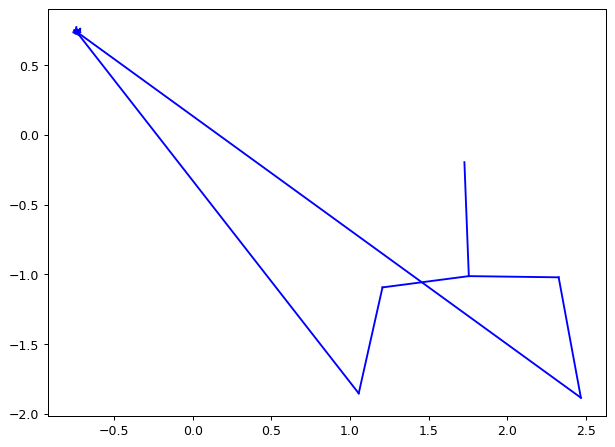

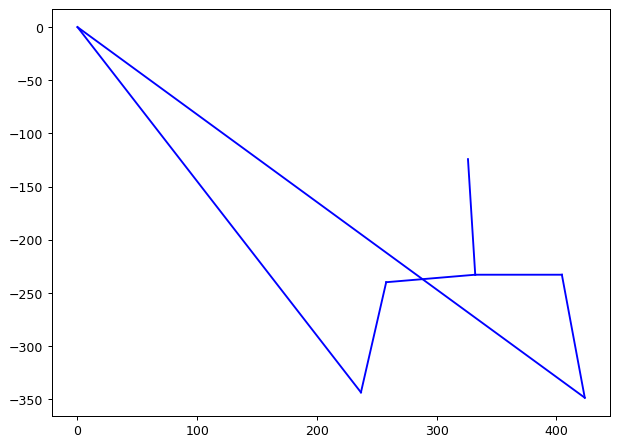

In [79]:
criterion = nn.MSELoss()
model = make_model()
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(train_loader, model, criterion, model_opt)

In [ ]:
# import pickle
# pickle.dump(dataset, open('dataset.pkl','wb'))

# A Real World Example

In [ ]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.
#Todo if not necessary remove later
BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

In [ ]:
# Create the model an load it onto our GPU.
model = make_model()
model_opt = get_std_opt(model)
model.cuda()

In [ ]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)


OTHER

In [ ]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [ ]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

In [ ]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [ ]:
print(pad_idx)
print(len(SRC.vocab))

In [ ]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

In [ ]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

In [ ]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118